# 🧮 Exercise 11.4 – Simulating the Heston Model in Python

In this exercise, we dive into the **Heston stochastic volatility model** – a popular model in quantitative finance for capturing the evolution of asset prices with **time-varying volatility**. Unlike the Black-Scholes model, the Heston model allows the variance to follow its own **mean-reverting stochastic process**, leading to more realistic dynamics.

Under the **risk-neutral measure** $\tilde{\mathbb{Q}}$, the model assumes:
- Two correlated Brownian motions $W^P_t$ and $W^v_t$ with correlation $\rho \in (-1,1)$.
- The dynamics:
  $$
  \begin{aligned}
  dP_t &= r P_t\,dt + \sqrt{v_t} P_t\,dW^P_t \\
  dv_t &= \kappa(\theta - v_t)\,dt + \alpha \sqrt{v_t}\,dW^v_t
  \end{aligned}
  $$
  where:
  - $P_t$ is the asset price,
  - $v_t$ is the stochastic variance,
  - $r$ is the risk-free rate,
  - $\kappa$ is the mean-reversion speed,
  - $\theta$ is the long-run variance,
  - $\alpha$ is the volatility of volatility, or *vol-vol*

## 🧑‍💻 Task A: Simulate Heston Price & Volatility Paths

Simulate one path of the **Heston model** under the risk-neutral measure $\tilde{\mathbb{Q}}$ using the Euler scheme:

$$
\begin{aligned}
P_{t+\Delta} &= P_t + rP_t\Delta + \sqrt{v_t}P_t\,\Delta W^P_t \\
v_{t+\Delta} &= v_t + \kappa(\theta - v_t)\Delta + \alpha \sqrt{v_t}\,\Delta W^v_t
\end{aligned}
$$

Use correlated Brownian increments:

$$\Delta W^P = \rho\,\Delta W^v + \sqrt{1 - \rho^2}\,\Delta W$$



In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [110]:
# DEFINE PARAMETERS
P0=     100
v0=     0.06
r=      0.05
kappa=  1
theta=  1
alpha=  0.3
rho=    -0.5
T=      20
n=      5000    #number of divisions of the time grid

In [132]:
def hestonPath(P0,v0,r,kappa,theta,alpha,rho,T,n):
    TimeGrid = np.linspace(0,T,n+1)
    dt = T / n
    Pt = np.zeros(n+1)
    vt = np.zeros(n+1)
    Pt[0] = P0
    vt[0] = v0
    for i in range(n):
        Z1,Z2 = np.random.standard_normal(2)
        dW_V = np.sqrt(dt) * Z1
        dW = np.sqrt(dt) * Z2
        dW_P = rho*dW_V + np.sqrt(1-rho*rho)*dW
        Pt[i+1] = Pt[i] * (1 + r*dt + np.sqrt(vt[i])*dW_P)
        vt[i+1] = vt[i] + kappa*(theta-vt[i])*dt + alpha*np.sqrt(vt[i])*dW_V
        vt[i+1] = max(0,vt[i+1]) # ensure that variance is positive for all events
    return TimeGrid,Pt,vt


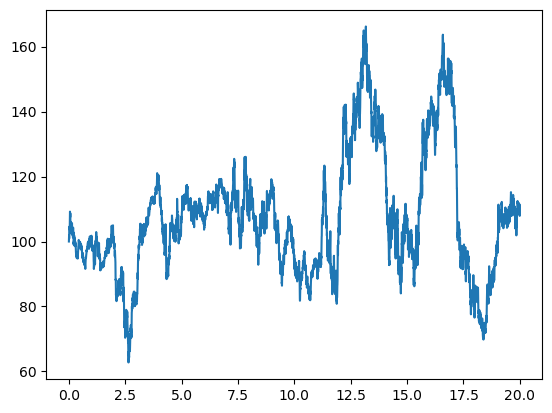

In [ ]:
TimeGrid, PriceProcess, VarProcess = hestonPath(P0,v0,r,kappa,theta,alpha,rho,T,n)
plt.plot(TimeGrid,PriceProcess)

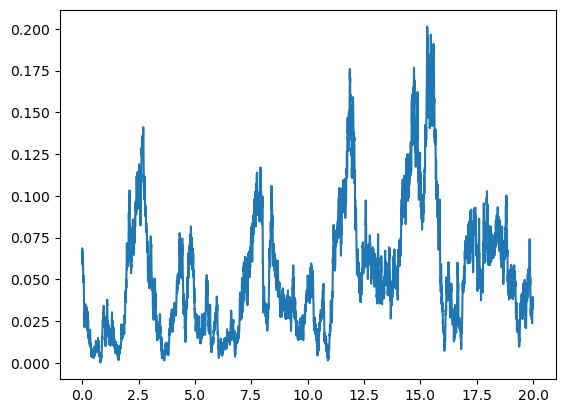

In [230]:
plt.plot(TimeGrid,VarProcess)

In [237]:
def MontecarloHeston(P0,v0,r,kappa,theta,alpha,rho,T,n,Msteps=1000):
    dt = T / n
    Pt = np.zeros((n+1,Msteps))
    Pt[0,:] = P0
    vt = np.zeros((n+1,Msteps))
    vt[0,:] = v0
    dW_v = np.sqrt(dt) * np.random.standard_normal((n,Msteps))
    dW_P = rho * dW_v + np.sqrt(1+rho*rho)*np.sqrt(dt)*np.random.standard_normal((n,Msteps))
    for i in range(n):
        Pt[i+1,:] = Pt[i,:] * (1 + r*dt + np.sqrt(vt[i,:])*dW_P[i,:])
        vt[i+1,:] = vt[i,:] + kappa*(theta-vt[i,:])*dt + alpha*np.sqrt(vt[i,:])*dW_v[i,:]
        vt[i+1,:] = (vt[i+1,:] + np.abs(vt[i+1,:])) / 2
    return np.linspace(0,T,n+1), Pt, vt

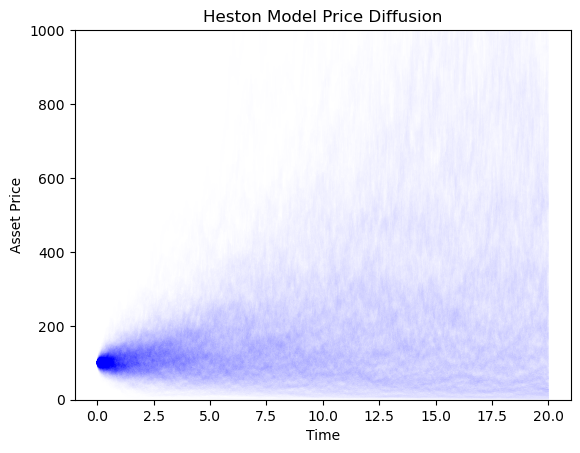

In [246]:
t, PriceDiffusion, VarianceDifussion = MontecarloHeston(P0,v0,r,kappa,theta,alpha,rho,T,n,Msteps=1_000)
plt.plot(t,PriceDiffusion,alpha=0.005,color='blue')

plt.title("Heston Model Price Diffusion")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(False)
plt.ylim((0,10*P0))
plt.show()
plt.show()

## 💰 Task B – Monte Carlo Pricing of a European Call Option under the Heston Model

Estimate the price of a European call option with:

- Strike price $ K = 100 $
- Maturity $ T = 1 $
- Risk-free rate $ r = 5\% $
- Underlying asset following the Heston model
- Monte Carlo simulation using:
  - $ n = 10 $ time steps
  - $ M = 100 $ simulated paths

In [298]:
P0, v0, r, kappa, theta, alpha, rho, T, n, m = 100, 0.06, 0.05, 1, 0.06, 0.3, -0.5, 20, 5000, 1000
T = 1
K = 100
t, PriceDiffusion, VarianceDifussion = MontecarloHeston(P0,v0,r,kappa,theta,alpha,rho,T,n,Msteps=10000)
discount = np.exp(-r*T)
Call = np.maximum(0,PriceDiffusion[n,:]-K)
CallPrice = np.mean(discount*Call)
print(CallPrice)

13.862482638782959
